In [10]:
from lbg_forecast.likelihood import Likelihood
import lbg_forecast.utils as utils

from lbg_forecast.angular_power import define_cosmo
from lbg_forecast.angular_power import pk
import lbg_forecast.angular_power as ap

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax_cosmo as jc

from uncertainties import unumpy as upy

In [2]:
path = "./"
lhood = Likelihood(path)

Initialising likelihood
Initialisation Complete


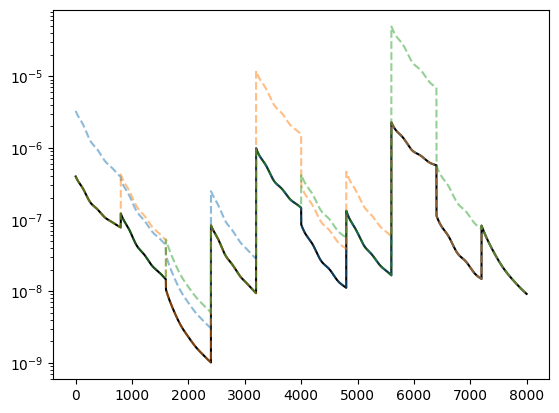

In [3]:
def get_params(du, dg, dr):

    params = np.array([lhood._cosmo_fid.sigma8, 
                    lhood._cosmo_fid.Omega_c, lhood._cosmo_fid.Omega_b,
                    lhood._cosmo_fid.h, lhood._cosmo_fid.n_s,
                    lhood._b_lbg_u+du, lhood._b_lbg_g+dg, lhood._b_lbg_r+dr])

    cosmo_obj = jc.Planck15(sigma8=params[0],
                            Omega_c=params[1],
                            Omega_b=params[2],
                            h=params[3],
                            n_s=params[4])

    bias_params = lhood._bias_params
    bias_params = bias_params.at[0].set(params[5])
    bias_params = bias_params.at[1].set(params[6])
    bias_params = bias_params.at[2].set(params[7])
    nz_params = lhood.nz_params_mean

    return cosmo_obj, nz_params, bias_params

cosmo_obj, nz_params, bias_params = get_params(0, 0, 0)
cl = ap.cl_theory_CMB(cosmo_obj, nz_params, bias_params, lhood._ell, lhood.ndens)

cosmo_obj, nz_params, bias_params = get_params(4, 0, 0)
cl_shift_u = ap.cl_theory_CMB(cosmo_obj, nz_params, bias_params, lhood._ell, lhood.ndens)

cosmo_obj, nz_params, bias_params = get_params(0, 10, 0)
cl_shift_g = ap.cl_theory_CMB(cosmo_obj, nz_params, bias_params, lhood._ell, lhood.ndens)

cosmo_obj, nz_params, bias_params = get_params(0, 0, 20)
cl_shift_r = ap.cl_theory_CMB(cosmo_obj, nz_params, bias_params, lhood._ell, lhood.ndens)

plt.plot(cl, c='k')
plt.plot(cl_shift_u, '--', alpha=0.5)
plt.plot(cl_shift_g, '--', alpha=0.5)
plt.plot(cl_shift_r, '--', alpha=0.5)

plt.yscale('log')

(90, 1200)

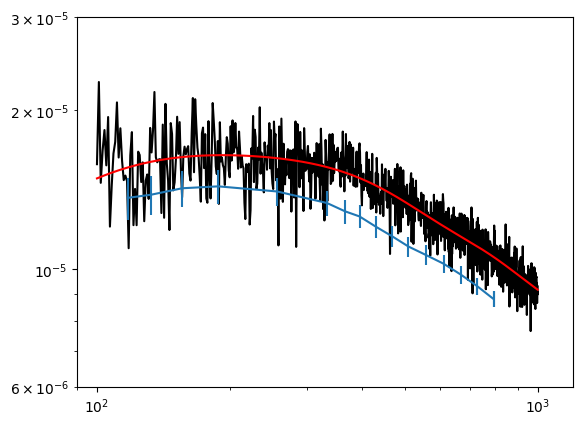

In [22]:
cosmo_obj, nz_params, bias_params = get_params(0, 0, 0)
ell = jnp.arange(100, 1000, 1)
cl, covmat = ap.cl_data_CMB(cosmo_obj, nz_params, bias_params, ell, 0.35, lhood.ndens, seed=100, ncls=4)
cmb_auto = jnp.squeeze(ap.cl_CMB_auto_theory(cosmo_obj, ell))

plt.plot(ell, ell*cl[len(ell)*9:], c='k')
plt.plot(ell, ell*cmb_auto, c='red')

x = np.array([117.43977082297401, 132.80159325948537, 155.9618867731977, 188.4317164143467, 256.2266095739562, 332.3231340683669, 365.282054455996, 393.987593415572, 428.9864076105732, 467.0942460883878, 508.5872905486948, 556.3907186959323, 611.5720633631457, 669.0552953100107, 728.4889992084929, 728.4889992084929, 793.2023342284294, 793.2023342284294])
y = np.array([0.000013652420392365202, 0.000013843996797624323, 0.000014235252169070247, 0.000014354770953081506, 0.000014038261482177314, 0.000013351397104075012, 0.000012876325185317335, 0.000012592414081133522, 0.00001204323378064385, 0.000011550149481308558, 0.000011046424419380268, 0.000010653368471495614, 0.000010245703975368026, 0.000009771597211815774, 0.000009293492280483563, 0.000009293492280483563, 0.000008789650226937582, 0.000008789650226937582])

cl_shaan = y/x
cosmic_var_sigma = np.sqrt((2/(2*x + 1)))*cl_shaan

ucl = upy.uarray(cl_shaan, cosmic_var_sigma)
ucl = ucl*x
lcl_shaan = []
lcl_shaan_errs = []
for i in range(len(ucl)):
    lcl_shaan.append(ucl[i].n)
    lcl_shaan_errs.append(ucl[i].s)


plt.errorbar(x, lcl_shaan, lcl_shaan_errs)

#cosmological parameters may be different!
plt.yscale('log')
plt.ylim(6e-6, 3e-5)
plt.xscale('log')
plt.xlim(90, 1200)
